In [1]:
import pandas as pd
import numpy as np
%matplotlib inline
from IPython.display import clear_output
import matplotlib.pyplot as plt
from progressbar import progressbar as pb

data = pd.read_csv('all_data_fixed3.csv', index_col=False)
data.head()

,0,1,2,3,4,5
0,Совещательный орган при императоре в начале XX в,Сенат,Государственный совет,Консилия министров,Верховный тайный совет,2
1,Министр внутренних дел с 1904 г либерал автор ...,Лорис Меликов,Святополк Мирский,Милюков,Витте,2
2,Какое из названных событий произошло 27 января...,подрыв флагманского корабля Петропавловск,высадка японских войск на Ляодунском полуострове,героический бой Варяга и Корейца,заключение Портсмутского мирного договора,3
3,Что из названного относится к результатам перв...,появление многопартийности,формирование конституционной монархии,ликвидация сословного строя,введение рабочего контроля за производством,1
4,Для выхода из экономического кризиса вызванног...,ввело 8 часовой рабочий день в промышленности,ликвидировало помещичье землевладение,отменило выкупные платежи,ввело продовольственную разверстку,4


In [2]:
import pickle

with open('Embeddings/elmo_embed3.pickle', 'rb') as f:
    elmo_embs = pickle.load(f)

elmo_embs = np.array(elmo_embs)

with open('Embeddings/bert_embed3.pickle', 'rb') as f:
    bert_embs = pickle.load(f)

bert_embs = np.array(bert_embs)

with open('Embeddings/fasttext_embed3.pickle', 'rb') as f:
    fasttext_embs = pickle.load(f)

fasttext_embs = np.array(fasttext_embs)

with open('Embeddings/rusvec_embed3.pickle', 'rb') as f:
    rusvec_embs = pickle.load(f)

rusvec_embs = np.array(rusvec_embs)

In [4]:
def get_samples(data, embeddings, train_part=0.75):
    
    '''
    Из вектора вопроса (q_vec) и векторов ответов (a1_vec, ... a2_vec) 
    создаем четыре вектора (q_vec | a1_vec), ... (q_vec | a2_vec) 
    с соответствующей бинарной разметкой, где | - конкатенация. 
    
    Делим выборку на трейн и тест.
    
    data - исходный датасет с разметкой
    embeddings - векторное представление исходного датасета
    train_part - доля тренировочной выборки
    
    return:
    
    X_train, X_test, y_train, y_test - разделенная на тренировочную и тестовую части выборка,
    имеющая вышеописанную структуру
    '''
    
    predata = np.zeros((embeddings.shape[0] * 4, embeddings.shape[2] * 2))
    target = []

    for i in range(len(data)):
        for j in range(1,5):
            cur_targ = 1 if j == int(data.iloc[i,5]) else 0
            cur_vec = np.hstack((embeddings[i,0], embeddings[i,j]))
            predata[i*4+j-1] = cur_vec
            target.append(cur_targ)
            
    all_inds = np.arange(embeddings.shape[0])
    train_size = int(len(all_inds) * train_part)
    train_inds = np.random.choice(all_inds, size=train_size, replace=False)
    test_inds = np.array(list(set(all_inds) - set(train_inds)))
    
    X_train, X_test, y_train, y_test = [],[],[],[]

    for i in range(len(train_inds)):
        for j in range(4):
            X_train.append(predata[train_inds[i] * 4 + j])
            y_train.append(target[train_inds[i] * 4 + j])

    for i in range(len(test_inds)):
        for j in range(4):
            X_test.append(predata[test_inds[i] * 4 + j])
            y_test.append(target[test_inds[i] * 4 + j])
            
    return np.array(X_train), np.array(X_test), np.array(y_train), np.array(y_test)

In [5]:
def get_batch(X_val, y_val, batch_sz=16, shuffle=True):
    
    '''
    Разбиение выборки на батчи заданного размера.
    
    X_val - векторное представление данных
    y_val - разметка
    batch_sz - размер одного батча
    shuffle - перемешивание элементов по батчам
    
    return:
    
    X_batches, y_batches - разделенная по батчам выборка    
    
    '''
    
    X_batches, y_batches = [], []
    
    samples_num = len(X_val)
    samples_inds = np.arange(samples_num)
    
    if shuffle:
        np.random.shuffle(samples_inds)
    
    cur_x, cur_y = [], []
    
    for i, cur_ind in enumerate(samples_inds):
        if i % batch_sz < batch_sz-1:
            cur_x.append(X_val[cur_ind])
            cur_y.append(y_val[cur_ind]-1)
        else:
            cur_x.append(X_val[cur_ind])
            cur_y.append(y_val[cur_ind]-1)
            X_batches.append(cur_x)
            y_batches.append(cur_y)
            cur_x, cur_y = [], []
          
    X_batches.append(cur_x)
    y_batches.append(cur_y)
    
    return np.array(X_batches), np.array(y_batches)

In [7]:
from sklearn.metrics import accuracy_score

def get_accuracy(preds, targets):
    
    '''
    Подсчет метрики точности для one-hot таргетов.
    
    preds - предсказанное значение ответа (в виде one-hot)
    targets - правильное значение ответа (в виде one-hot)
    
    return:
    
    Значение accuracy для входных данных.
    
    '''
    
    preds, targets = np.concatenate(preds, axis=0), np.concatenate(targets, axis=0)
    y_pred_splitted, y_target_splitted = [], []
    
    for i in range(len(preds) // 4):
        y_pred_splitted.append(np.argmax(preds[i*4:i*4+4]))
        y_target_splitted.append(np.argmax(targets[i*4:i*4+4]))
        
    return accuracy_score(y_target_splitted, y_pred_splitted)

In [8]:
import torch
import torch.nn as nn

class SiameseNet(nn.Module):
    def __init__(self, embed_size):
        super().__init__()
        self.left = nn.Sequential(
                                nn.Linear(embed_size, embed_size * 3 // 4),
                                nn.ReLU(),
                                nn.Linear(embed_size * 3 // 4, embed_size // 2),
                                nn.ReLU())
        
        self.right = nn.Sequential(
                                nn.Linear(embed_size, embed_size * 3 // 4),
                                nn.ReLU(),
                                nn.Linear(embed_size * 3 // 4, embed_size // 2),
                                nn.ReLU())
        
        self.center = nn.Sequential(
                                nn.Linear(embed_size, embed_size // 2),
                                nn.ReLU(),
                                nn.Linear(embed_size // 2, embed_size // 4),
                                nn.ReLU(),
                                nn.Linear(embed_size // 4, 1),
                                nn.Sigmoid())
            
    def forward(self, q, a):
        left = self.left(q)
        right = self.right(a)
        x = torch.cat((left, right), 1)
        out = self.center(x)
        
        return out

In [9]:
def train(model, optimizer, X_train, y_train, batch_size, shuffle):
    train_loss, all_preds, all_tests = [], [], []
    model.train()
    
    X_batches, y_batches = get_batch(X_test, y_test, batch_size, shuffle)
        
    for batch in zip(X_batches, y_batches):
        X_batch, y_batch = batch
        X_batch, y_batch = np.array(X_batch), np.array(y_batch)
        embed_shape_tr = X_batch.shape[1] // 2
        
        X_batch = torch.from_numpy(X_batch).type(torch.cuda.FloatTensor)
        y_batch = torch.from_numpy(y_batch).type(torch.cuda.LongTensor)
    
        optimizer.zero_grad()
        y_pred = model(X_batch[:,:embed_shape_tr], X_batch[:, embed_shape_tr:])[:,0]

        loss = loss_fn(y_pred, y_batch.type(torch.cuda.FloatTensor))
        
        train_loss.append(loss.item())
        
        loss.backward()
        optimizer.step()
        
        all_preds.append(y_pred.detach().cpu().numpy())
        all_tests.append(y_batch.cpu().numpy())
    
    accuracy = get_accuracy(np.array(all_preds), np.array(all_tests))
        
    return np.mean(train_loss), accuracy

In [10]:
def validate(model, optimizer, X_test, y_test, batch_size, shuffle):
    val_loss, all_preds, all_tests = [], [], []
    model.eval()
    
    X_batches, y_batches = get_batch(X_test, y_test, batch_size, shuffle)
        
    
    for batch in zip(X_batches, y_batches):
        X_batch, y_batch = batch
        X_batch, y_batch = np.array(X_batch), np.array(y_batch)
        embed_shape_tr = X_batch.shape[1] // 2
        
        X_batch = torch.from_numpy(X_batch).type(torch.cuda.FloatTensor)
        y_batch = torch.from_numpy(y_batch).type(torch.cuda.LongTensor)
    
        y_pred = model(X_batch[:,:embed_shape_tr], X_batch[:, embed_shape_tr:])[:,0]
        
        loss = loss_fn(y_pred, y_batch.type(torch.cuda.FloatTensor))
        
        val_loss.append(loss.item())
        all_preds.append(y_pred.detach().cpu().numpy())
        all_tests.append(y_batch.cpu().numpy())
        
    accuracy = get_accuracy(np.array(all_preds), np.array(all_tests))
        
    return np.mean(val_loss), accuracy

In [11]:
def launch_net(model, optimizer, X_train, y_train, X_test, y_test, shuffle=True,\
               train_batch=64, test_batch=16, epochs=25):
    all_train_loss, all_val_loss = [], []
    all_train_acc, all_val_acc = [], []
    max_acc = 0

    for epoch in pb(range(epochs)):
        cur_train = train(model, optimizer, X_train, y_train, train_batch, shuffle)
        cur_val = validate(model, optimizer, X_test, y_test, test_batch, shuffle)
        all_train_loss.append(cur_train[0])
        all_train_acc.append(cur_train[1])
        all_val_loss.append(cur_val[0])
        all_val_acc.append(cur_val[1])
        max_acc = cur_val[1] if cur_val[1] > max_acc else max_acc
        clear_output()
        print('Epoch {}:'.format(epoch+1))
        print("Train loss: {}".format(cur_train[0]))
        print("Validation loss: {}".format(cur_val[0]))
        print("Train accuracy: {}".format(cur_train[1]))
        print("Validation accuracy: {}".format(cur_val[1]))
        print("Max validation accuracy: {}".format(max_acc))
        
        f, axarr = plt.subplots(1,2, figsize=(20,10))

        axarr[0].plot(all_train_loss, label='Train loss')
        axarr[0].plot(all_val_loss, label='Val loss')
        axarr[0].grid()
        axarr[0].legend(fontsize=15)
        axarr[0].set_title('Loss after epoch #{}'.format(epoch+1), size=15)

        axarr[1].plot(all_train_acc, label='Train accuracy')
        axarr[1].plot(all_val_acc, label='Val accuracy')
        axarr[1].grid()
        axarr[1].legend(fontsize=15)
        axarr[1].set_title('Accuracy after epoch #{}'.format(epoch+1), size=15)
        plt.show()

# Fasttext

In [31]:
embeddings = fasttext_embs

In [32]:
model = SiameseNet(embeddings.shape[2]).cuda()
optimizer = torch.optim.Adam(model.parameters())
loss_fn = nn.BCELoss()
epochs = 10

In [33]:
X_train, X_test, y_train, y_test = get_samples(data, embeddings)

Epoch 10:
Train loss: 0.13735892955164
Validation loss: 1.7818978960255543
Train accuracy: 0.7745809357017763
Validation accuracy: 0.3057228915662651
Max validation accuracy: 0.33207831325301207


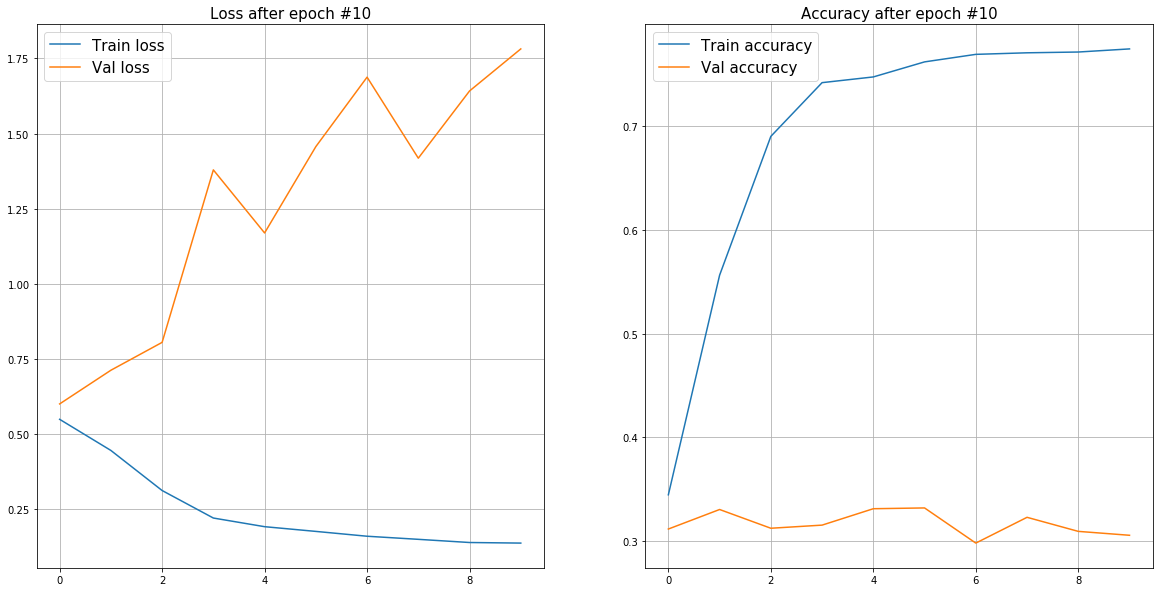

100% (10 of 10) |########################| Elapsed Time: 0:03:01 Time:  0:03:01


In [34]:
launch_net(model, optimizer, X_train, y_train, X_test, y_test, True, 64, 16, epochs)

In [35]:
model = SiameseNet(embeddings.shape[2]).cuda()
optimizer = torch.optim.Adam(model.parameters())
loss_fn = nn.BCELoss()
epochs = 10

Epoch 10:
Train loss: 0.3868617959438808
Validation loss: 0.7089825329326448
Train accuracy: 0.7122842131598699
Validation accuracy: 0.3533383345836459
Max validation accuracy: 0.3533383345836459


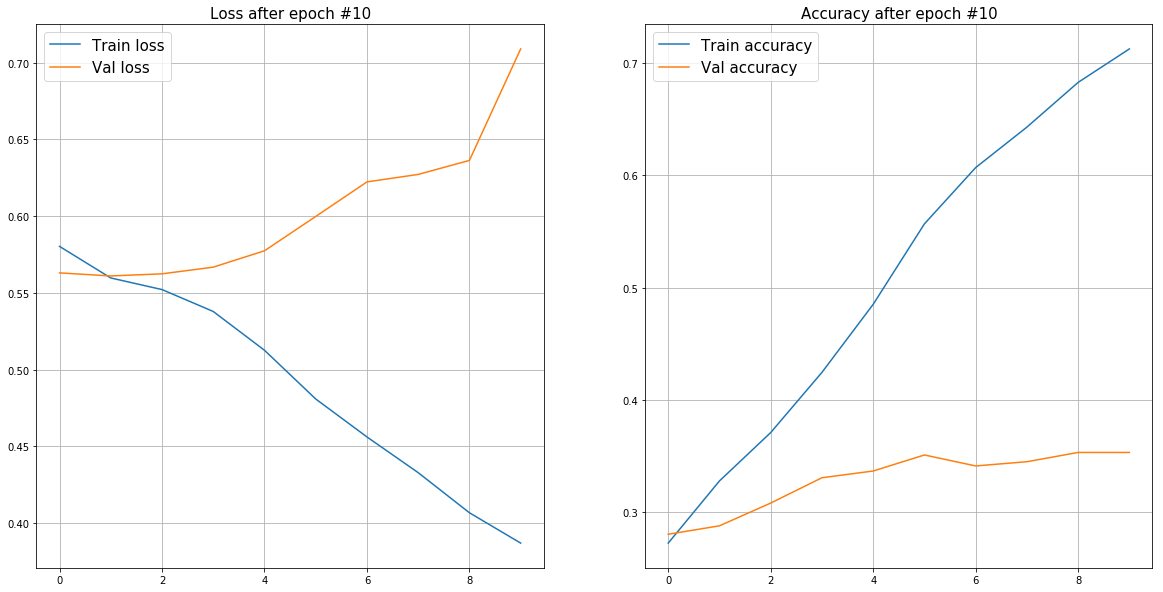

100% (10 of 10) |########################| Elapsed Time: 0:00:11 Time:  0:00:11


In [36]:
launch_net(model, optimizer, X_train, y_train, X_test, y_test, False, 64, 16, epochs)

# ELMO

In [39]:
embeddings = elmo_embs
X_train, X_test, y_train, y_test = get_samples(data, embeddings)

In [42]:
model = SiameseNet(embeddings.shape[2]).cuda()
optimizer = torch.optim.Adam(model.parameters())
loss_fn = nn.BCELoss()
epochs = 10

Epoch 10:
Train loss: 0.1471788768177583
Validation loss: 1.7204187964818565
Train accuracy: 0.769827370527896
Validation accuracy: 0.31099397590361444
Max validation accuracy: 0.33207831325301207


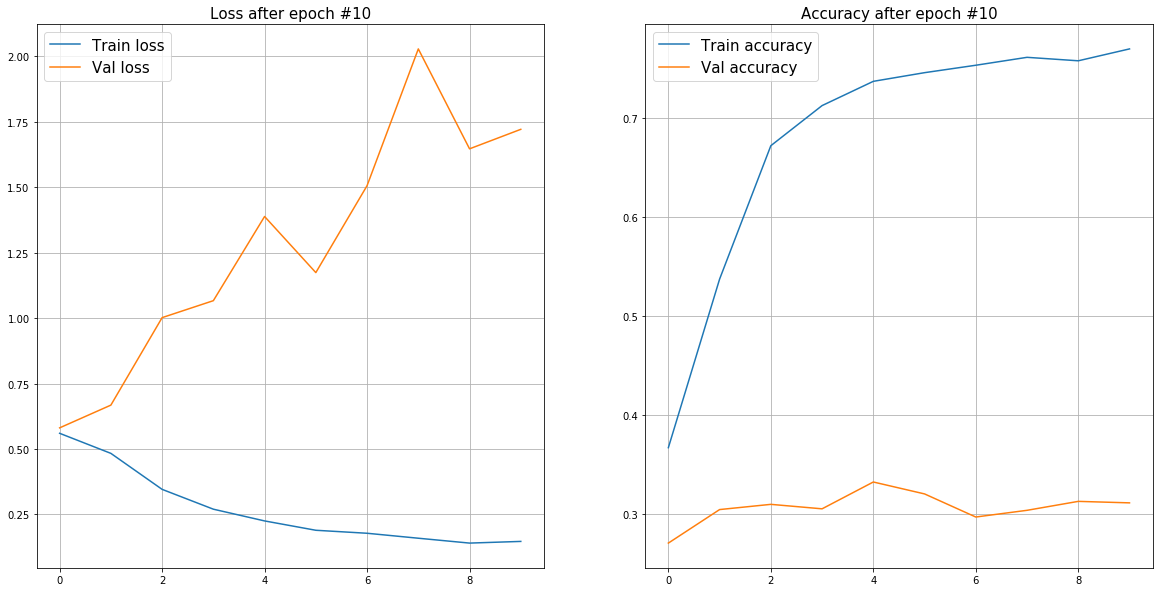

100% (10 of 10) |########################| Elapsed Time: 0:07:47 Time:  0:07:47


In [43]:
launch_net(model, optimizer, X_train, y_train, X_test, y_test, True, 64, 16, epochs)

In [44]:
embeddings = elmo_embs
X_train, X_test, y_train, y_test = get_samples(data, embeddings)

In [45]:
model = SiameseNet(embeddings.shape[2]).cuda()
optimizer = torch.optim.Adam(model.parameters())
loss_fn = nn.BCELoss()
epochs = 10

Epoch 10:
Train loss: 0.3230276218955479
Validation loss: 0.967705487495377
Train accuracy: 0.7760820615461597
Validation accuracy: 0.3570892723180795
Max validation accuracy: 0.3668417104276069


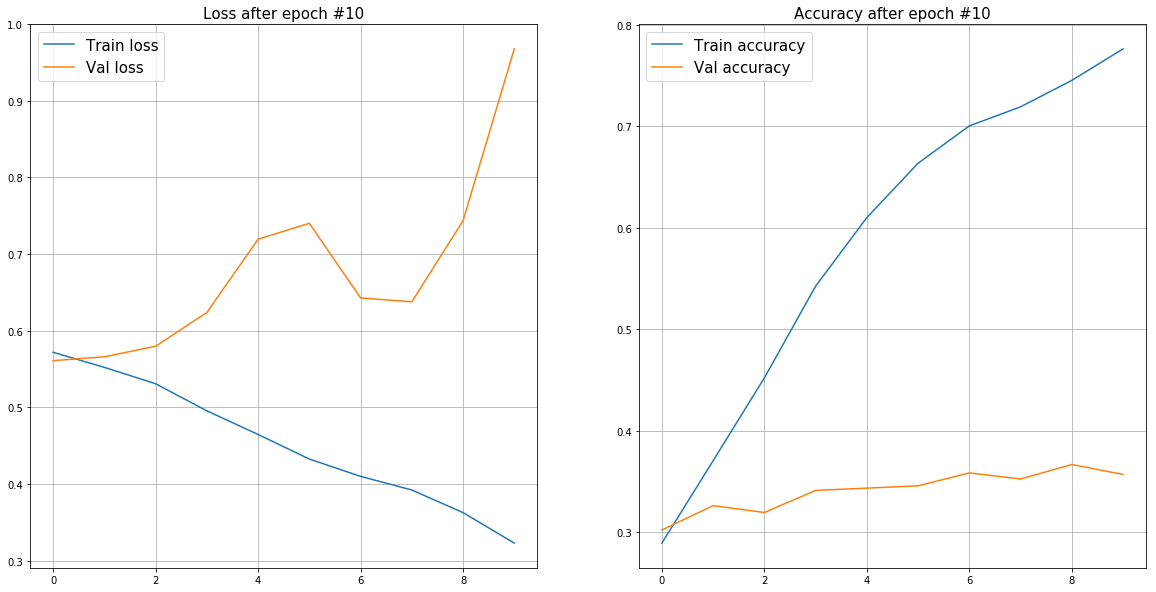

100% (10 of 10) |########################| Elapsed Time: 0:00:23 Time:  0:00:23


In [46]:
launch_net(model, optimizer, X_train, y_train, X_test, y_test, False, 64, 16, epochs)

# BERT

In [47]:
embeddings = bert_embs
X_train, X_test, y_train, y_test = get_samples(data, embeddings)

In [48]:
model = SiameseNet(embeddings.shape[2]).cuda()
optimizer = torch.optim.Adam(model.parameters())
loss_fn = nn.BCELoss()
epochs = 10

Epoch 10:
Train loss: 0.1915147478602711
Validation loss: 1.5270445224750473
Train accuracy: 0.7513134851138353
Validation accuracy: 0.31551204819277107
Max validation accuracy: 0.32379518072289154


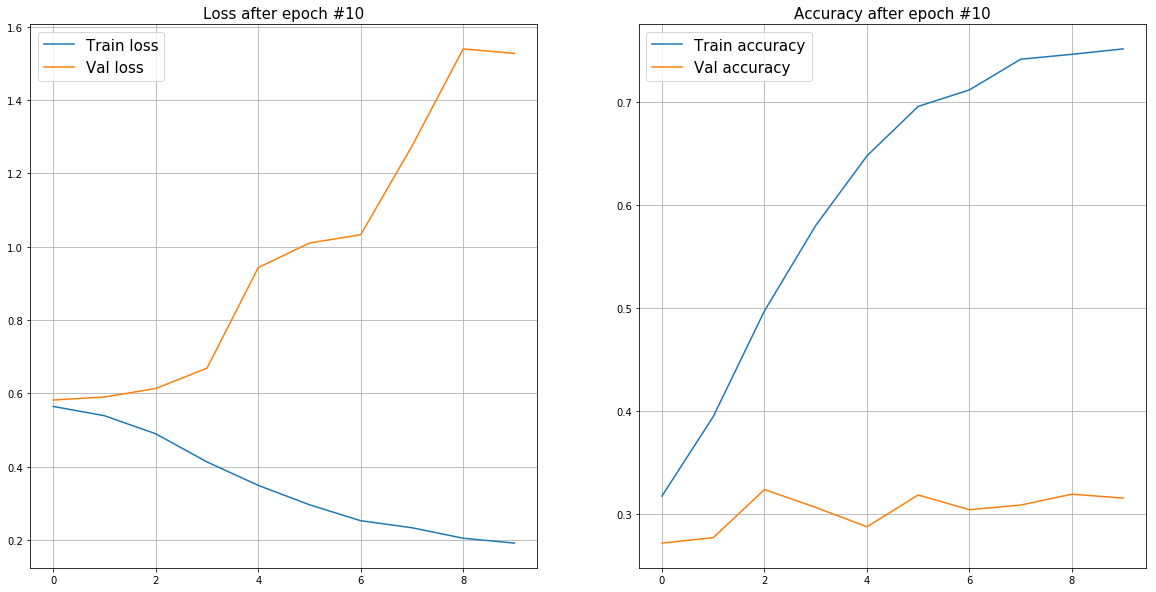

100% (10 of 10) |########################| Elapsed Time: 0:04:46 Time:  0:04:46


In [49]:
launch_net(model, optimizer, X_train, y_train, X_test, y_test, True, 64, 16, epochs)

In [50]:
embeddings = bert_embs
X_train, X_test, y_train, y_test = get_samples(data, embeddings)

In [51]:
model = SiameseNet(embeddings.shape[2]).cuda()
optimizer = torch.optim.Adam(model.parameters())
loss_fn = nn.BCELoss()
epochs = 10

Epoch 10:
Train loss: 0.4910307398864201
Validation loss: 0.6027516516901198
Train accuracy: 0.5258944208156117
Validation accuracy: 0.2933233308327082
Max validation accuracy: 0.31207801950487624


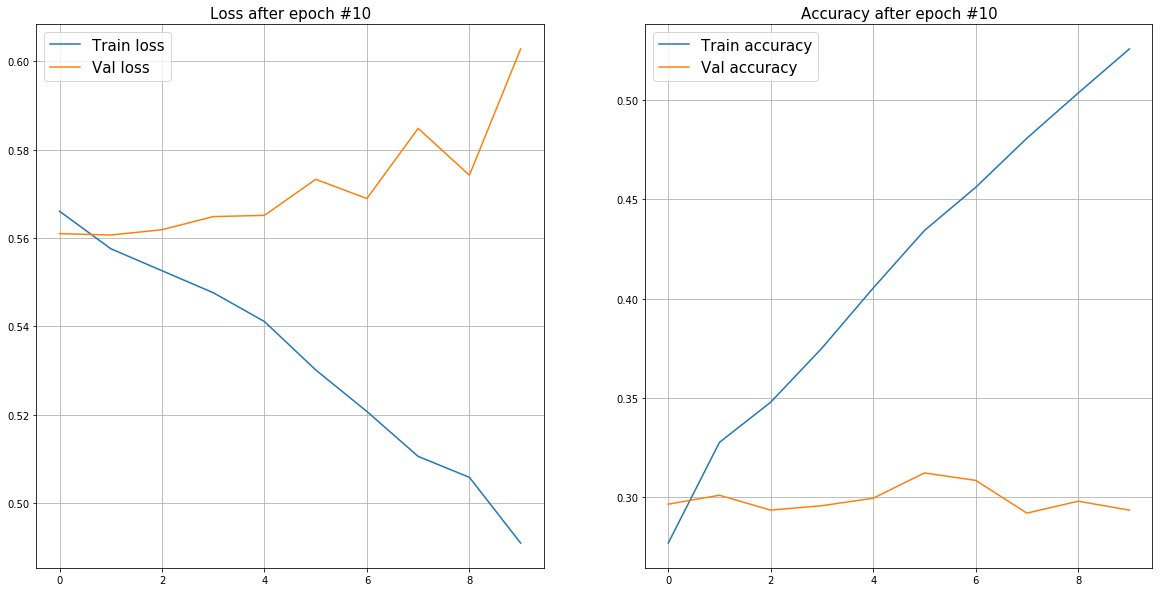

100% (10 of 10) |########################| Elapsed Time: 0:00:15 Time:  0:00:15


In [52]:
launch_net(model, optimizer, X_train, y_train, X_test, y_test, False, 64, 16, epochs)

# RusVectores

In [12]:
embeddings = rusvec_embs
X_train, X_test, y_train, y_test = get_samples(data, embeddings)

In [13]:
model = SiameseNet(embeddings.shape[2]).cuda()
optimizer = torch.optim.Adam(model.parameters())
loss_fn = nn.BCELoss()
epochs = 10

Epoch 10:
Train loss: 0.1880862380282658
Validation loss: 1.0968270721923874
Train accuracy: 0.7262947210407806
Validation accuracy: 0.3200301204819277
Max validation accuracy: 0.338855421686747


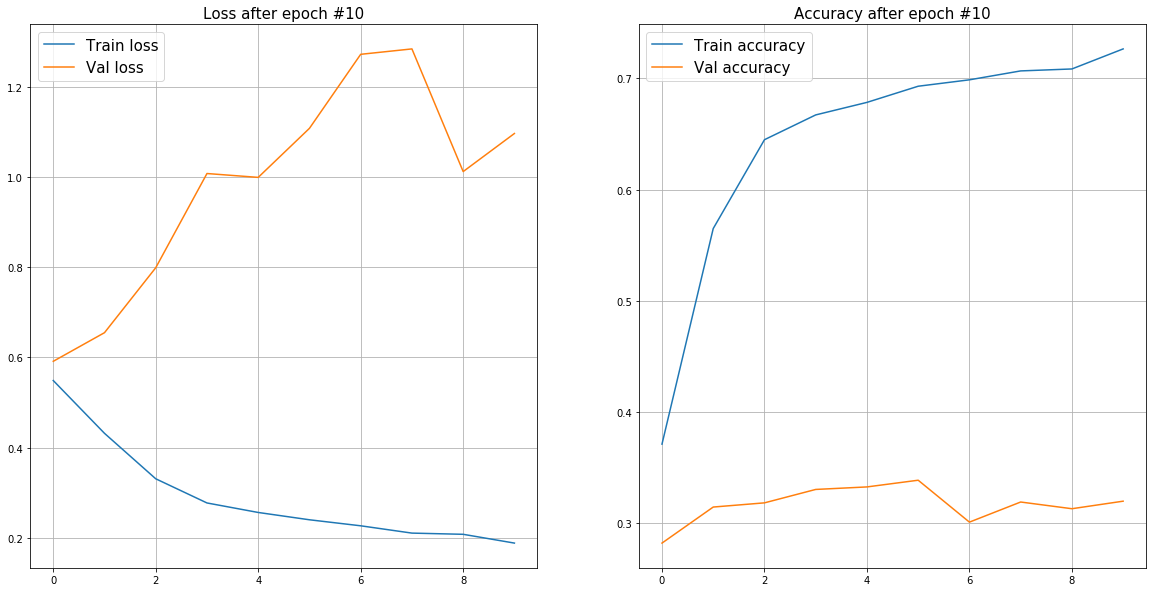

100% (10 of 10) |########################| Elapsed Time: 0:03:02 Time:  0:03:02


In [14]:
launch_net(model, optimizer, X_train, y_train, X_test, y_test, True, 64, 16, epochs)

Epoch 10:
Train loss: 0.5100313098657698
Validation loss: 0.5706418539796557
Train accuracy: 0.4761070803102327
Validation accuracy: 0.3210802700675169
Max validation accuracy: 0.3225806451612903


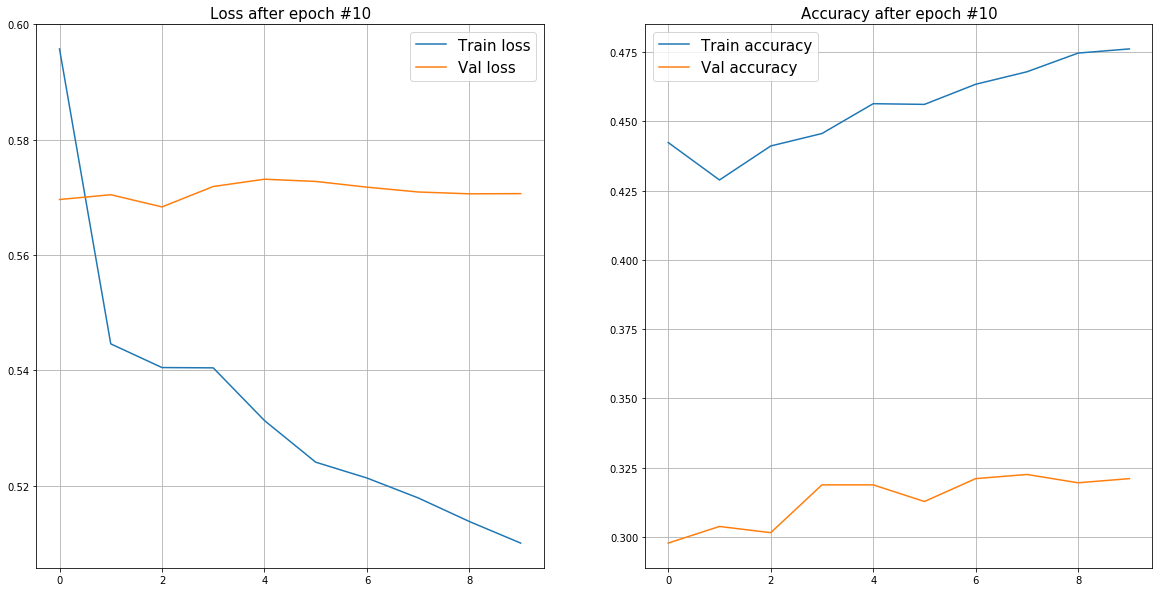

100% (10 of 10) |########################| Elapsed Time: 0:00:12 Time:  0:00:12


In [15]:
launch_net(model, optimizer, X_train, y_train, X_test, y_test, False, 64, 16, epochs)